In [9]:
#paper 2(Numerical  Study of a Strongly Coupled Two-scale System with Nonlinear Dispersion, Section 5.3 Table 3)
#Scheme 2 pre computing (Numerics) congergence oreder in sapce

#import libraries
from dolfin import *
import mshr
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
set_log_active(False)

In [10]:
#Geometry for micro problem

L = 1.0 #lenght of domain
W = 1.0 #width of the domain

#center of ellipse
x_0 = 0.85
y_0 = 0.75
x_1 = 0.35
y_1  =  0.1
x_2 = 0.175
y_2  =  0.8
center0 = Point(x_0, y_0)
center1 = Point(x_1, y_1)
center2 = Point(x_2, y_2)

#axis of elllipse
horizontal_semi_axis_0 = 0.1
vertical_semi_axis_0 = 0.2
horizontal_semi_axis_1 = 0.30
vertical_semi_axis_1 = 0.08
horizontal_semi_axis_2 = 0.15
vertical_semi_axis_2 = 0.15

def Geometry1(ny):
    # Define domain for cell probem 
    #define geometry 1
    geometry = mshr.Rectangle(Point(0.0, 0.0), Point(1.0, 1.0)) \
         - mshr.Ellipse(center0, horizontal_semi_axis_0, vertical_semi_axis_0, 100) - mshr.Ellipse(center1, horizontal_semi_axis_1, vertical_semi_axis_1, 100) \
           - mshr.Ellipse(center2, horizontal_semi_axis_2, vertical_semi_axis_2, 100)
    # Build mesh
    mesh1 = mshr.generate_mesh(geometry, ny)
    return mesh1

In [11]:
#solve stoke problem
from dolfin import *
import mshr
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
set_log_active(False)
# Define domain for cell probem and B
#mesh = Geometry1(ny)

###periodic boundary conndition
class PeriodicBoundary(SubDomain):
    # Left boundary is "target domain" G
    def inside(self, x, on_boundary):
    # return True if on left or bottom boundary AND NOT on one of the two corners (0, 1) and (1, 0)
        return bool((near(x[0], 0) or near(x[1], 0)) and 
                (not ((near(x[0], 0) and near(x[1], 1)) or 
                        (near(x[0], 1) and near(x[1], 0)))) and on_boundary)
    def map(self, x, y):
        if near(x[0], 1) and near(x[1], 1):
            y[0] = x[0] - 1
            y[1] = x[1] - 1
        elif near(x[0], 1):
            y[0] = x[0] - 1
            y[1] = x[1]
        else:   # near(x[1], 1)
            y[0] = x[0]
            y[1] = x[1] - 1
PbcUnit = PeriodicBoundary() 

# Construct facet markers
def STOKE(mesh):
    bndry = MeshFunction("size_t", mesh, mesh.topology().dim()-1) 
    for f in facets(mesh):
        mp = f.midpoint()
        if ((mp[0]- x_0)/horizontal_semi_axis_0)**2 + ((mp[1]-y_0)/vertical_semi_axis_0)**2 <=1: # elllipse is marked as 5
            bndry[f] = 5
        elif ((mp[0]- x_1)/horizontal_semi_axis_1)**2 + ((mp[1]-y_1)/vertical_semi_axis_1)**2 <=1: # elllipse is marked as 5
            bndry[f] = 5
        elif ((mp[0]- x_2)/horizontal_semi_axis_2)**2 + ((mp[1]-y_2)/vertical_semi_axis_2)**2 <=1: # elllipse is marked as 5
            bndry[f] = 5     

    #define a finite element space
    P0 = VectorElement('P', mesh.ufl_cell(), 2) #  Here  we used the Taylor-Hood element, second order Lagrange basis element for each component of velocity and first order for pressure   
    P1 = FiniteElement('P', mesh.ufl_cell(), 1) #  first order lagrange element  for pressure.
    TH = P0 * P1 

    W = FunctionSpace(mesh, TH, constrained_domain = PbcUnit) # Mixed function space with periodic boundary condition in outer boundary
    BC_value_circle = Constant((0, 0)) #Boundary value on the inner circle
    bc_circle = DirichletBC(W.sub(0), BC_value_circle, bndry, 5) #Impelemntation of BC on inner circle
    # Collect boundary conditions
    bcs = [bc_circle]
    # Facet normal, and boundary measure
    n = FacetNormal(mesh)
    I = Identity(mesh.geometry().dim())
    ds = Measure("ds", subdomain_data=bndry)
    nu = Constant(0.01)
    F = Expression(("10*(sin(2*pi*x[0])*sin(2*pi*x[1]))", '10*(sin(2*pi*x[0])*cos(2*pi*x[1]))'), degree =2)

    def stokes():
        # Define variational forms for Stokes
        def a(u,v):
            return inner(nu*grad(u), grad(v))*dx
        def b(p,v):
            return p*div(v)*dx
        def L(v):
            return inner(F, v)*dx
        # Solve the problem
        B, p = TrialFunctions(W)
        v, q = TestFunctions(W)
        w = Function(W)
        solve(a(B, v) - b(p, v) + b(q, B) == L(v), w, bcs, solver_parameters={'linear_solver' : 'mumps'})
        #solve(a(B, v) - b(p, v) + b(q, B) == L(v), w, bcs) I need to dertermine solver_parameter not to get error of memory
        return w

    if __name__ == "__main__":
        for problem in [stokes]:
            begin("Running '%s'" % problem.__name__)

            # Call solver
            w = problem()

            # Extract solutions
            B, p = w.split()
            plt.colorbar(plot((B)))
            plt.title("$B$")
            plt.show()
            end()
    return B            



In [12]:
#Precomputing# auxuliary problem (Input: a vector of p values, B, mesh; our put: entries of D_star matrix )
from dolfin import *
import mshr
import numpy as np
import matplotlib.pyplot as plt

def D_star(p, B_y, mesh):
    
    #### Defining D(y) matirx with D_11, D_12, D_21, D_22 component
    D_11 = Expression('2 +sin(pi*x[0])*sin(pi*x[1])', degree =1) #fast diffusion case 
    D_12 = Constant(0)
    D_21 = Constant(0)
    D_22 = Expression('2 + sin(2*pi*x[0])', degree =1) #fast diffusion case 
    D = as_matrix([[D_11, D_12],[D_21, D_22]])
    e_1 = as_vector([1, 0])
    e_2 = as_vector([0, 1])
    P2 = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
    R2 = FiniteElement("Real", mesh.ufl_cell(), 0)
    area = assemble(Constant(1.0)*dx(mesh)) #Area of the domain
    function_space = FunctionSpace(mesh, P2 * R2, constrained_domain = PbcUnit)
    D_HOM_11 = []
    D_HOM_12 = []
    D_HOM_21 = []
    D_HOM_22 = []
    
    for i in range(number_of_points):
        (w1, c) = TrialFunction(function_space)
        (v, d) = TestFunction(function_space) 
        a_1 = dot(D*grad(w1), grad(v))*dx(domain=mesh) - dot(Constant(p[i])*B_y*w1, grad(v))*dx(domain=mesh) + c*v*dx(domain=mesh) + w1*d*dx(domain=mesh)
        L_1 =   -dot(D*e_1, grad(v))*dx(domain=mesh) 
        W1 = Function(function_space)
        solve(a_1 == L_1, W1)
        (w1, c) = W1.split()
        if i == 57:
            plt.colorbar(plot(w1))
            plt.show()
        (w2, c1) = TrialFunction(function_space)
        (v1, d1) = TestFunction(function_space)
        a_2 = dot(D*grad(w2), grad(v1))*dx(domain=mesh) - dot(Constant(p[i])*B_y*w2, grad(v1))*dx(domain=mesh) + c1*v1*dx(domain=mesh) + w2*d1*dx(domain=mesh)
        L_2 = - dot(D*e_2, grad(v1))*dx(domain=mesh)
        
        # Compute cell solution w_2
        W2 = Function(function_space)
        solve(a_2 == L_2, W2)
        (w2, c1) = W2.split()
        #plt.plot(w2)
        D_hom_11 =  (1/area)*(assemble(dot(D_11, (1 + w1.dx(0)))*dx(domain=mesh)) + assemble(dot(D_12,  w1.dx(1))*dx(domain=mesh)))
        D_hom_12 =  (1/area)*(assemble(dot(D_11, w2.dx(0))*dx(domain=mesh)) + assemble(dot(D_12, (1+ w2.dx(1)))*dx(domain=mesh)))
        D_hom_21 =  (1/area)*(assemble(dot(D_22, w1.dx(1))*dx(domain=mesh)) + assemble(dot(D_21, (1 + w1.dx(0)))*dx(domain=mesh)))
        D_hom_22 =  (1/area)*(assemble(dot(D_21, w2.dx(0))*dx(domain=mesh)) + assemble(dot(D_22, (1 + w2.dx(1)))*dx(domain=mesh))) 
        D_HOM_11.append(D_hom_11) #store D_hom_11 value for each vertix and store them in the lise D_HOM_11. 
        D_HOM_12.append(D_hom_12)  #store D_hom_12 value for each vertix and store them in the lise D_HOM_12. 
        D_HOM_21.append(D_hom_21)  #store D_hom_21 value for each vertix and store them in the lise D_HOM_21. 
        D_HOM_22.append(D_hom_22)  #store D_hom_22 value for each vertix and store them in the lise D_HOM_22.
    return D_HOM_11, D_HOM_12, D_HOM_21, D_HOM_22

dt= 0.00625
H= 0.31943828249997
number of vetrix= 64


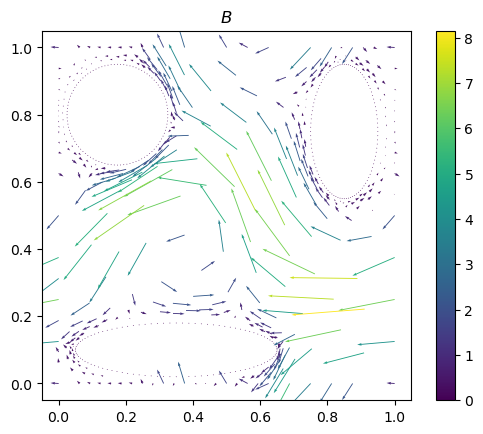

number of vetrix in micro= 692


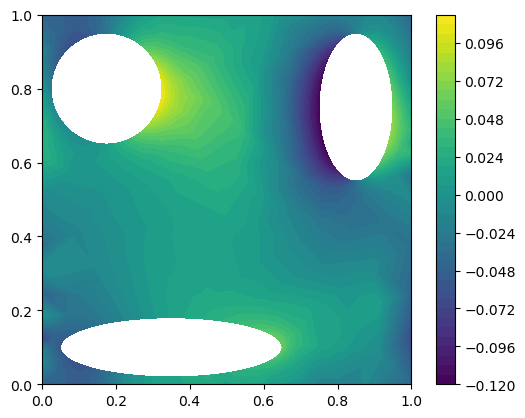

computation time= 17.609566688537598 seconds
dt= 0.003125
H= 0.1490711984999862
number of vetrix= 256


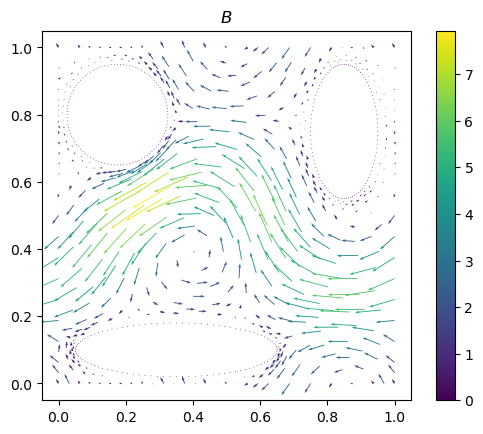

number of vetrix in micro= 836


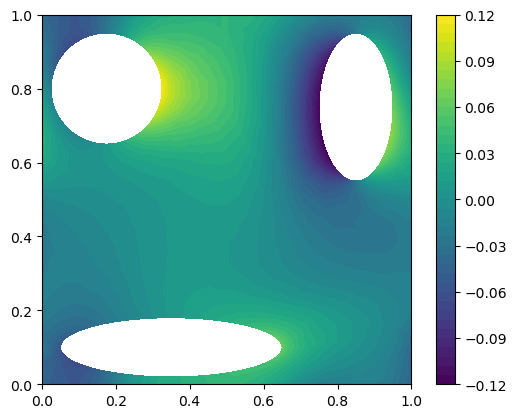

computation time= 71.24353790283203 seconds
dt= 0.0015625
H= 0.07213122508063856
number of vetrix= 1024


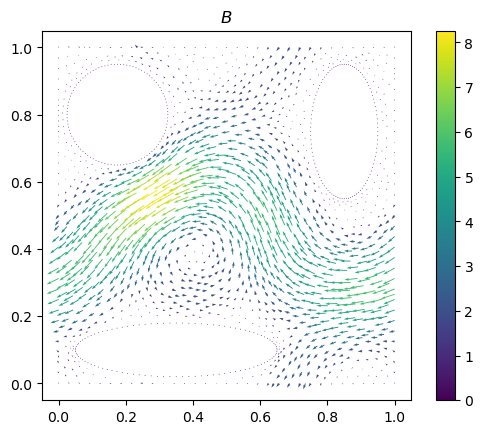

number of vetrix in micro= 1641


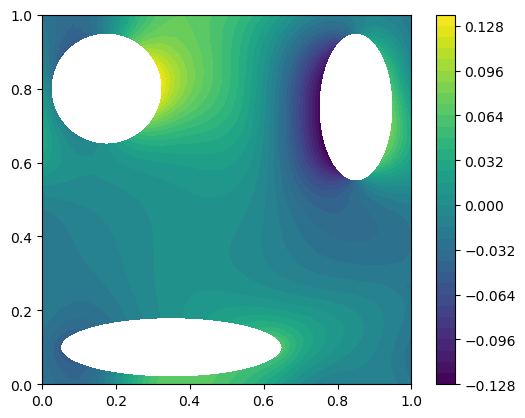

computation time= 371.30832052230835 seconds
dt= 0.00078125
H= 0.035493142499996785
number of vetrix= 4096


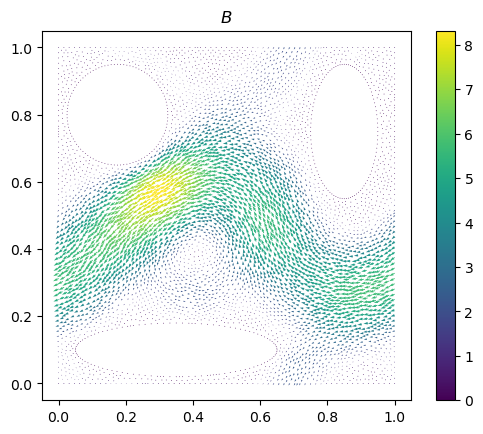

number of vetrix in micro= 5288


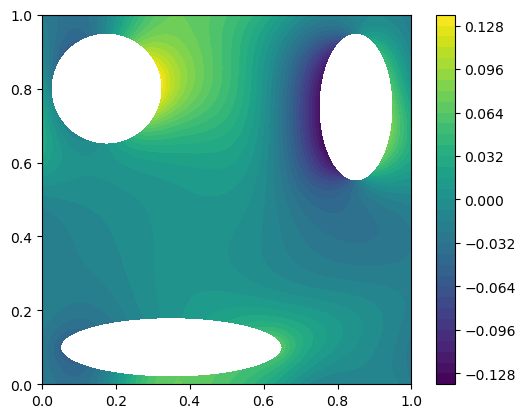

computation time= 2789.3886098861694 seconds
dt= 0.000390625
H= 0.017606834468502496
number of vetrix= 16384


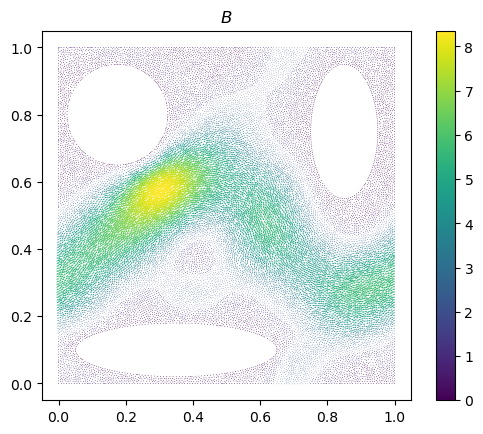

number of vetrix in micro= 20517


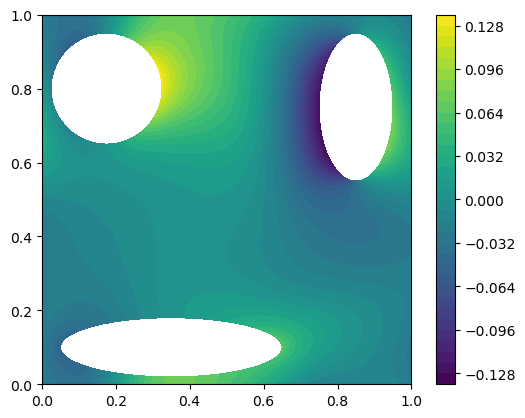

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
computation time= 20622.87093091011 seconds


In [6]:
#Method2 Precomputing (convergence with  double nx in micro, double ny in macro and double M time)
from dolfin import *
import mshr
import numpy as np
import matplotlib.pyplot as plt
import time
U_scheme_2_pre = []
U_scheme_2_pre_vertex = []
start_time = time.time()
x_in = 0 
x_end = 1 
y_in = 0
y_end = 2

L = 1.0
W = 1.0
T = 2 #
#u_in  = Constant(1.0) #intitlal iteration function 
u_in =  Expression("exp(-10*(pow((x[0]-0.5),2) + pow((x[1]-0.5), 2)))*(pow(x[0]-0.5,2)+pow(x[1]-0.5,2) < 1.0/16.0)", degree =2)
#u_in = Expression("10*(sin(2*pi*x[0]))", degree =2)
#f = Expression("1000*exp(-10*(pow((x[0]-0.5),2) + pow((x[1]-0.5), 2)))*(pow(x[0]-0.5,2)+pow(x[1]-0.5,2) < 0.5 )", degree =2)
f = Expression("1000*(pow(x[0]-0.5,2)+pow(x[1]-0.5,2) < 1.0/16.0)", degree =2)
#f = Expression("10*(2 + (sin(2*pi*x[0])*sin(2*pi*x[1])))", degree =2)

nxs = np.array([8, 16, 32, 64, 128], dtype=int)
Ms = 40*np.array([8, 16, 32, 64, 128], dtype=int)
micro_nxs = np.array([8, 16, 32, 64, 128], dtype=int)
Hs_scheme2_pre = []
###########  #total nodes in x and y directions for macro domain (Omega)
for nx, M, nx_micro  in zip(nxs, Ms, micro_nxs):
    Mesh = RectangleMesh(Point(x_in, y_in), Point(x_end, y_end), nx-1, nx-1) #mesh for u macro domain (Omega)
    
    mesh = Geometry1(nx_micro)
    print('h=', mesh.hmax())
    #make a numpy array with 201 elements 
    x1 = -np.logspace( 0, 10, 50, endpoint=True)[::-1]*10
    x2 = np.linspace(x1[-1], -x1[-1], 101)
    x3 = np.logspace(0, 10, 50, endpoint=True)*10
    p_i = np.concatenate((x1, x2, x3), axis=0)
    XX = np.sort(p_i)
    number_of_points = len(XX)
    dt = T/M
    print('dt=', dt)
    print('H=', Mesh.hmax())
    Hs_scheme2_pre.append(Mesh.hmax())
    number_of_vertices = Mesh.num_vertices()
    print('number of vetrix=', number_of_vertices )
    B = STOKE(mesh)
    number_of_microvertices = mesh.num_vertices()
    print('number of vetrix in micro=', number_of_microvertices )
    D_hom = D_star(XX, B, mesh)
    V =  FunctionSpace(Mesh, 'Lagrange', 1) # finite element space with lagrange element of degree 1
    u_n = interpolate(u_in, V) #interpolation of initial iteration function on finite element space
    #u_n = u_0 #initial condition for each iteration 
    U_0 = u_n.compute_vertex_values(Mesh) # list of the iterpolated values of u_0
    #U_0_time = [U_0] # vertex values for each time step after  iterpolation the initial iteration function 
    def Boundary_condition(x, on_boundary):
        return on_boundary
    bc = DirichletBC(V, Constant(0.0), Boundary_condition) # zero Dirichlet boundary condition
    def G(u):
        return 1- 2*u

    UU_T =[]
    UU_store = []
    UU_store.append(u_n)
    u_store = []
    u_store.append(U_0)
    t = 0
    for j in range(M):
        D_INTERPOLATE_11 = []
        D_INTERPOLATE_12 = []
        D_INTERPOLATE_21 = []
        D_INTERPOLATE_22 = []
        
        for i in range(number_of_vertices):
        #def D_star_interpolate(x_array, y_array, x_new):
            D_interpolate_11 = np.interp(G(U_0[i]), XX, D_hom[0])
            D_interpolate_12 = np.interp(G(U_0[i]), XX, D_hom[1])
            D_interpolate_21 = np.interp(G(U_0[i]), XX, D_hom[2])
            D_interpolate_22 = np.interp(G(U_0[i]), XX, D_hom[3])
            
            #append 
            D_INTERPOLATE_11.append(D_interpolate_11) 
            D_INTERPOLATE_12.append(D_interpolate_12) 
            D_INTERPOLATE_21.append(D_interpolate_21) 
            D_INTERPOLATE_22.append(D_interpolate_22)  
            
        d2v = dof_to_vertex_map(V) #A map that maps the dof to vetrix
        
        # list of Vertex_values_D_11 in a way that FEniCS can define a fenics function from the discrete data of D_HOM_11, D_HOM_12,D_HOM_21, D_HOM_22 
        Vertex_values_D_11 = [D_INTERPOLATE_11[d2v[i]] for i in range(number_of_vertices)]   
        Vertex_values_D_12 = [D_INTERPOLATE_12[d2v[i]] for i in range(number_of_vertices)]
        Vertex_values_D_21 = [D_INTERPOLATE_21[d2v[i]] for i in range(number_of_vertices)]
        Vertex_values_D_22 = [D_INTERPOLATE_22[d2v[i]] for i in range(number_of_vertices)]
        
        ###initializing the each component of  D^* to a  function (componenetwise) in function space V
        D_star_11 = Function(V)
        D_star_12 = Function(V)
        D_star_21 = Function(V)
        D_star_22 = Function(V)
        
        ###assigning the discrete calculated values Vertex_values_D_11 to a function D_star_11 function. Similar for other components.
        D_star_11.vector()[:] = Vertex_values_D_11
        D_star_12.vector()[:] = Vertex_values_D_12
        D_star_21.vector()[:] = Vertex_values_D_21
        D_star_22.vector()[:] = Vertex_values_D_22 
    
        #construct a matrix from the component. we will use this mattrix D_star_k_plus_1 in macro problem.   
        D_star_k_plus_1 = as_matrix([[D_star_11,  D_star_12],[ D_star_21,  D_star_22]])
        t = t + dt
        #print(t)
        #f.t = t
        u = TrialFunction(V)
        v = TestFunction(V)

        F = u*v*dx + dt*dot(D_star_k_plus_1*grad(u), grad(v))*dx(domain=Mesh) - (u_n + dt*f)*v*dx(domain=Mesh) 
        a, L = lhs(F), rhs(F)
        u = Function(V)
        #t = t +dt
        solve(a == L, u, bc)
        #plt.colorbar(plot(u))
        #plt.show()
        UU_store.append(u)#store each time step solution u in UU_store list
        vertex_values_u = u.compute_vertex_values(Mesh) #compute the vertex value for each time step solution
        #print(vertex_values_u)
        u_store.append(vertex_values_u) #store the vertex values solution in u_store list
        u_n = u.copy() #assign the computed solution to a new u_n  
        U_0 =  vertex_values_u.copy()
    U_scheme_2_pre.append(UU_store) 
    U_scheme_2_pre_vertex.append(u_store)
    end_time = time.time()
    print('computation time=', (end_time - start_time), 'seconds')

In [29]:
#interpolation over time interval 
print(len(U_scheme_2_pre_vertex))
M_4 = U_scheme_2_pre_vertex[0]
#np.save("Scheme2_precompute_macro_micro_time_vary/scheme2_pre_u_nx_8M_320nxmicro_8.npy", M_4)
M_8 = U_scheme_2_pre_vertex[1]
#np.save("Scheme2_precompute_macro_micro_time_vary/scheme2_pre_u_nx_16M_640nxmicro_16.npy", M_8)
M_16 = U_scheme_2_pre_vertex[2]
#np.save("Scheme2_precompute_macro_micro_time_vary/scheme2_pre_u_nx_32M_1280nxmicro_32.npy", M_16)
M_32 = U_scheme_2_pre_vertex[3]
#np.save("Scheme2_precompute_macro_micro_time_vary/scheme2_pre_u_nx_64M_2560nxmicro_64.npy", M_32)
M_64 = U_scheme_2_pre_vertex[4]
#np.save("Scheme2_precompute_macro_micro_time_vary/scheme2_pre_u_nx_128M_5120nxmicro_128.npy", M_64)
M_4_copy = M_4.copy()
for i in range(len(M_4)-1):
    #print(i)
    interpolate = (M_4[i] + M_4[i+1])/2
    M_4_copy = np.insert(M_4_copy, 2*i+1, interpolate, axis = 0)
print(len(M_4_copy))
#print(M_4_copy)

M_8_copy = M_8.copy()
for i in range(len(M_8)-1):
    #print(i)
    interpolate = (M_8[i] + M_8[i+1])/2
    #print('Interpolate=', interpolate )
    M_8_copy = np.insert(M_8_copy, 2*i+1, interpolate, axis = 0)
#print(len(M_8_copy))
#print(M_8_copy)

M_16_copy = M_16.copy()
for i in range(len(M_16)-1):
    #print(i)
    interpolate = (M_16[i] + M_16[i+1])/2
    #print('Interpolate=', interpolate )
    M_16_copy = np.insert(M_16_copy, 2*i+1, interpolate, axis = 0)
print(len(M_16_copy))
#print(M_16_copy)

M_32_copy = M_32.copy()
for i in range(len(M_32)-1):
    #print(i)
    interpolate = (M_32[i] + M_32[i+1])/2
    M_32_copy = np.insert(M_32_copy, 2*i+1, interpolate, axis = 0)
print(len(M_32_copy))
#print(M_32_copy)

M_64_copy = M_64.copy()
for i in range(len(M_64)-1):
    #print(i)
    interpolate = (M_64[i] + M_64[i+1])/2
    M_64_copy = np.insert(M_64_copy, 2*i+1, interpolate, axis = 0)
print(len(M_64_copy))

#np.save("Scheme2_precompute_macro_micro_time_vary/scheme2_pre_u_nx_8M_320nxmicro_8_interpolation.npy", M_4_copy)

#np.save("Scheme2_precompute_macro_micro_time_vary/scheme2_pre_u_nx_16M_640nxmicro_16_interpolation.npy", M_8_copy)

#np.save("Scheme2_precompute_macro_micro_time_vary/scheme2_pre_u_nx_32M_1280nxmicro_32_interpolation.npy", M_16_copy)

#np.save("Scheme2_precompute_macro_micro_time_vary/scheme2_pre_u_nx_64M_2560nxmicro_64_interpolation.npy", M_32_copy)

#np.save("Scheme2_precompute_macro_micro_time_vary/scheme2_pre_u_nx_128M_5120nxmicro_128_interpolation.npy", M_64_copy)
U_scheme_2_pre_vertex_inter = [M_4_copy, M_8_copy, M_16_copy, M_32_copy, M_64_copy]

5
641
2561
5121
10241


In [8]:

U_solution = []

#nxs = np.array([4, 8, 16, 32, 64], dtype=int)
#Ms = np.array([4, 8, 16, 32, 64], dtype=int)
#micro_nxs = np.array([1, 2, 4, 8, 16], dtype=int)
###########  #total nodes in x and y directions for macro domain (Omega)
for nx, s in zip(nxs, range(len(nxs))):
    Mesh = RectangleMesh(Point(x_in, y_in), Point(x_end, y_end), nx-1, nx-1) #mesh for u macro domain (Omega)
    V =  FunctionSpace(Mesh, 'Lagrange', 1) # finite element space with lagrange element of degree 1
    number_of_vertices = Mesh.num_vertices() 
    U_solution_nx = []
    for i in range(len(U_scheme_2_pre_vertex_inter[s])):
        #print(len(U_scheme_2_pre_vertex_inter[s][i]))
        d2v = dof_to_vertex_map(V) #A map that maps the dof to vetrix
        #print(number_of_vertices)
        Vertex_values = [U_scheme_2_pre_vertex_inter[s][i][d2v[j]] for j in range(number_of_vertices)]   
        U = Function(V)
        ###assigning the discrete calculated values Vertex_values_D_11 to a function D_star_11 function. Similar for other components.
        U.vector()[:] = Vertex_values
        U_solution_nx.append(U)
        #plt.colorbar(plot(U))
        #plt.show()
    #plot(U)    
    U_solution.append(U_solution_nx)
    

In [12]:

import math 
start_time = time.time()
Error_in_scheme2_pre = []
#T = 0.1
M = 320
dt = T/M
Dt = [dt, dt/2, dt/4, dt/8, dt/16]
print(Dt)
for i in range(len(U_solution)-1):
    print(i)
    Errors_in_nx = []
    for j in range(len(U_solution[i])):
        #print(j)
        #print(len(U_solution[i]))
        #print(len(U_scheme_2_pre[i+1]))
        #error_in_time_slice = errornorm(U_solution[i][2*j], U_scheme_2_pre[i+1][2*j], norm_type ='L2')
        error_in_time_slice = errornorm(U_scheme_2_pre[i+1][j], U_solution[i][j], norm_type ='L2')
        #print(error_in_time_slice)
        Errors_in_nx.append(error_in_time_slice**2)
    Error_in_L_2_T = np.sqrt(Dt[i]*np.sum(Errors_in_nx))
    print(Dt[i])
    Error_in_scheme2_pre.append(Error_in_L_2_T)  
print('Error_in_scheme2 in precomputing=', Error_in_scheme2_pre)  

#Computing convergence rate
convergence_rate =[]
def convergence_order():
    for i in range(len(Error_in_scheme2_pre)-1):
        rate = math.log(Error_in_scheme2_pre[i]/Error_in_scheme2_pre[i+1])/math.log(Hs_scheme2_pre[i]/Hs_scheme2_pre[i+1])
        #rate = math.log((Error_in_scheme2_pre[i]/Error_in_scheme2_pre[i+1]), 2)
        convergence_rate.append(rate)
    return convergence_rate
RATE = convergence_order()
end_time = time.time()
computational_time = end_time - start_time
print('Computational time =', computational_time, 'seconds')
print('convergence order of scheme 2 precomputing=', RATE)    


[0.00625, 0.003125, 0.0015625, 0.00078125, 0.000390625]
0
0.00625
1
0.003125
2
0.0015625
3
0.00078125
Error_in_scheme2 in precomputing= [2.2453911838070995, 0.8857862289901866, 0.2575236643709861, 0.07216579558110447]
Computational time = 2833.0071721076965 seconds
convergence order of scheme 2 precomputing= [1.2204572955131485, 1.7017510098678992, 1.7939080217036758]


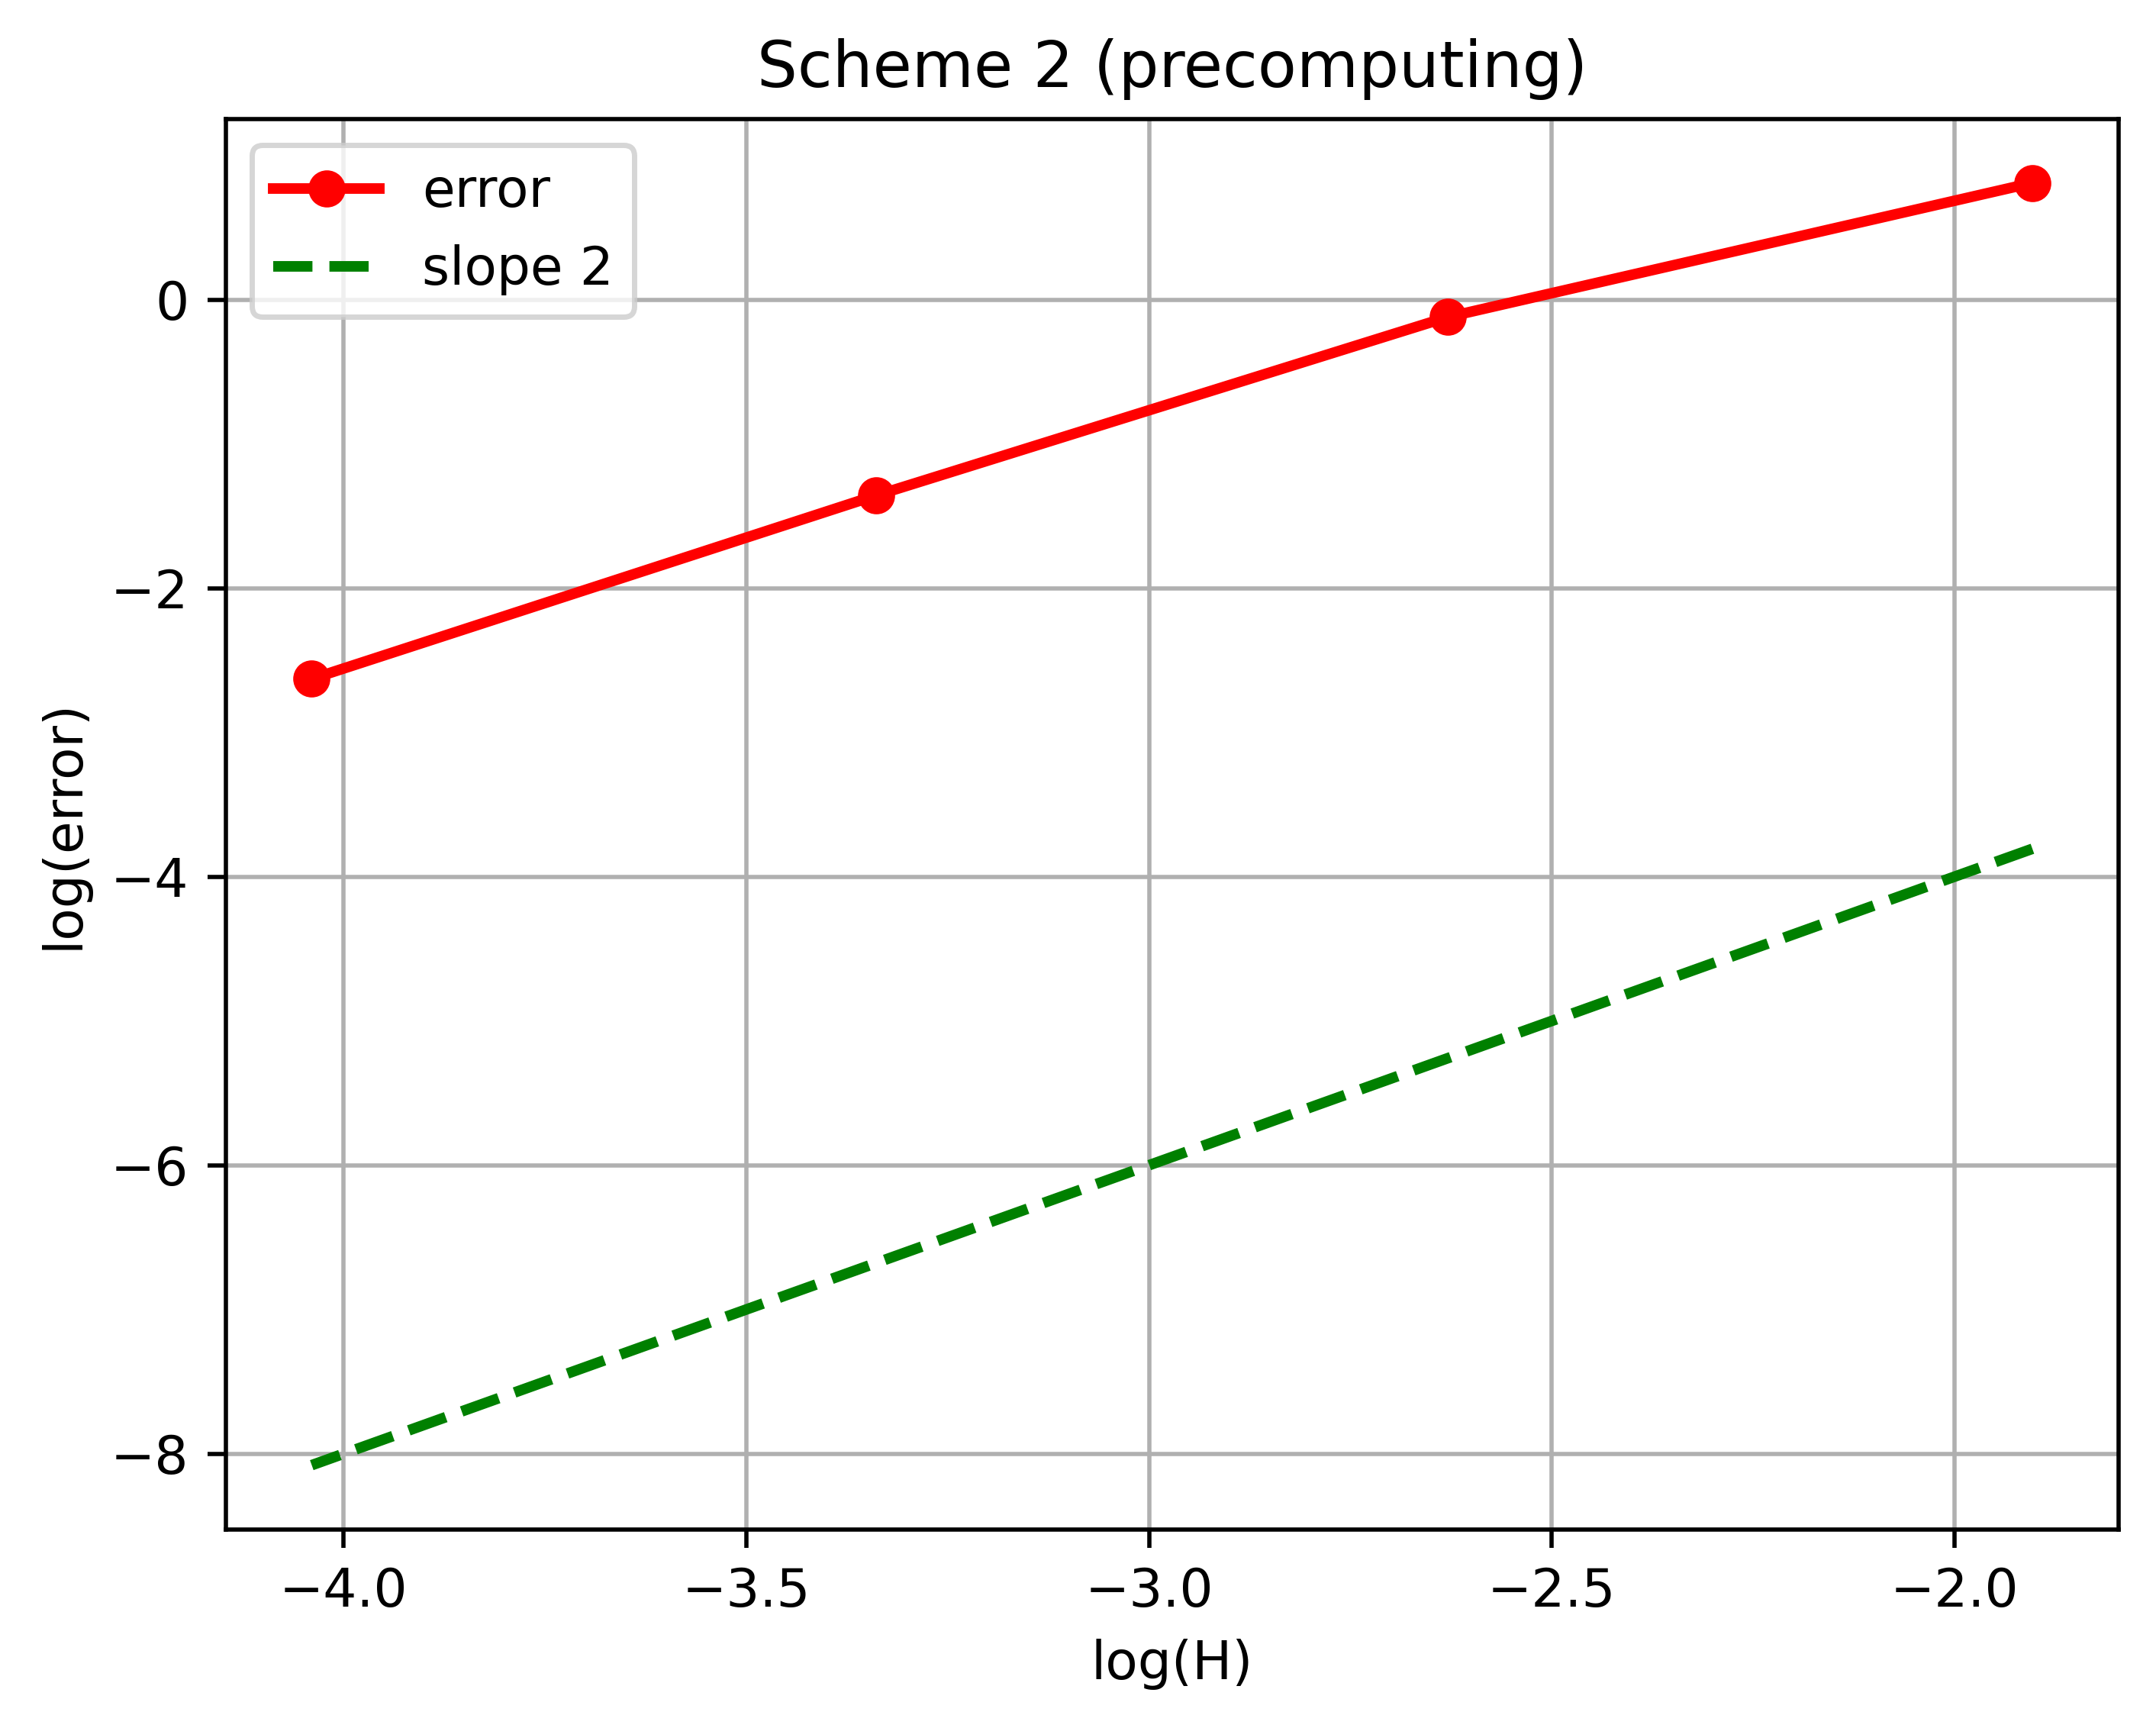

In [7]:
import matplotlib.pyplot as plt
import numpy as np
Error_in_scheme2_pre = [2.2453911838070995, 0.8857862289901866, 0.2575236643709861, 0.07216579558110447]
Hs_scheme2_pre = [0.31943828249997, 0.1490711984999862, 0.07213122508063856, 0.035493142499996785, 0.017606834468502496]
plt.figure(dpi=500)
#plt.plot(np.log(NX[:-1]), np.log(Error_scheme2), 'r-o', linewidth=2)
plt.plot(np.log(Hs_scheme2_pre[1:]), np.log(Error_in_scheme2_pre), 'r-o', linewidth=2)
#plt.plot(np.log(NX[:-1]), np.log(Error_scheme1), 'r-o', linewidth=2)
#plt.plot(np.log(NX[:-1]), np.log(Error_scheme1_pre), 'r-o', linewidth=2)
#plt.plot(np.log(nxs[1:]), -2*np.log(nxs[1:]), 'g--', linewidth=2)
plt.plot(np.log(Hs_scheme2_pre[1:]), 2*np.log(Hs_scheme2_pre[1:]), 'g--', linewidth=2)

plt.legend([r'error', r'slope 2'])
plt.title('Scheme 2 (precomputing)')
plt.xlabel('log(H)')
plt.ylabel('log(error)')
plt.grid()
plt.show()

In [13]:
from dolfin import *
import mshr
import numpy as np
import matplotlib.pyplot as plt
import time
#U_scheme_2_pre = []
#U_scheme_2_pre_vertex = []
start_time = time.time()
x_in = 0 
x_end = 1 
y_in = 0
y_end = 2

L = 1.0
W = 1.0
T = 2 #
#u_in  = Constant(1.0) #intitlal iteration function 
u_in =  Expression("exp(-10*(pow((x[0]-0.5),2) + pow((x[1]-0.5), 2)))*(pow(x[0]-0.5,2)+pow(x[1]-0.5,2) < 1.0/16.0)", degree =2)
#u_in = Expression("10*(sin(2*pi*x[0]))", degree =2)
#f = Expression("1000*exp(-10*(pow((x[0]-0.5),2) + pow((x[1]-0.5), 2)))*(pow(x[0]-0.5,2)+pow(x[1]-0.5,2) < 0.5 )", degree =2)
f = Expression("1000*(pow(x[0]-0.5,2)+pow(x[1]-0.5,2) < 1.0/16.0)", degree =2)
#f = Expression("10*(2 + (sin(2*pi*x[0])*sin(2*pi*x[1])))", degree =2)

nxs = np.array([8, 16, 32, 64, 128], dtype=int)
Ms = 40*np.array([8, 16, 32, 64, 128], dtype=int)
micro_nxs = np.array([8, 16, 32, 64, 128], dtype=int)
#Hs_scheme2_pre = []
###########  #total nodes in x and y directions for macro domain (Omega)
for nx, M, nx_micro  in zip(nxs, Ms, micro_nxs):
    Mesh = RectangleMesh(Point(x_in, y_in), Point(x_end, y_end), nx-1, nx-1) #mesh for u macro domain (Omega)
    
    mesh = Geometry1(nx_micro)
    print('h=', mesh.hmax())
    number_of_microvertices = mesh.num_vertices()
    print('number of vetrix in micro=', number_of_microvertices )
    

h= 0.1564604820040087
number of vetrix in micro= 692
h= 0.07918584167473604
number of vetrix in micro= 838
h= 0.03977068498610376
number of vetrix in micro= 1641
h= 0.019886451010497037
number of vetrix in micro= 5288
h= 0.009943546907000595
number of vetrix in micro= 20517


In [2]:
import math
Error_in_scheme= [2.2453911838070995, 0.8857862289901866, 0.2575236643709861, 0.07216579558110447]
hs = [0.15646, 0.07918,  0.039770, 0.0198864, 0.009943 ]
#Computing convergence rate
convergence_rate1 =[]
def convergence_order():
    for i in range(len(Error_in_scheme)-1):
        rate = math.log(Error_in_scheme[i]/Error_in_scheme[i+1])/math.log(hs[i]/hs[i+1])
        #rate = math.log((Error_in_scheme2_pre[i]/Error_in_scheme2_pre[i+1]), 2)
        convergence_rate1.append(rate)
    return convergence_rate1
RATE = convergence_order()
#end_time = time.time()
#computational_time = end_time - start_time
#print('Computational time =', computational_time, 'seconds')
print('convergence order of scheme 2 precomputing=', RATE)    


convergence order of scheme 2 precomputing= [1.3657191068392023, 1.7939943443778543, 1.8355043309975019]


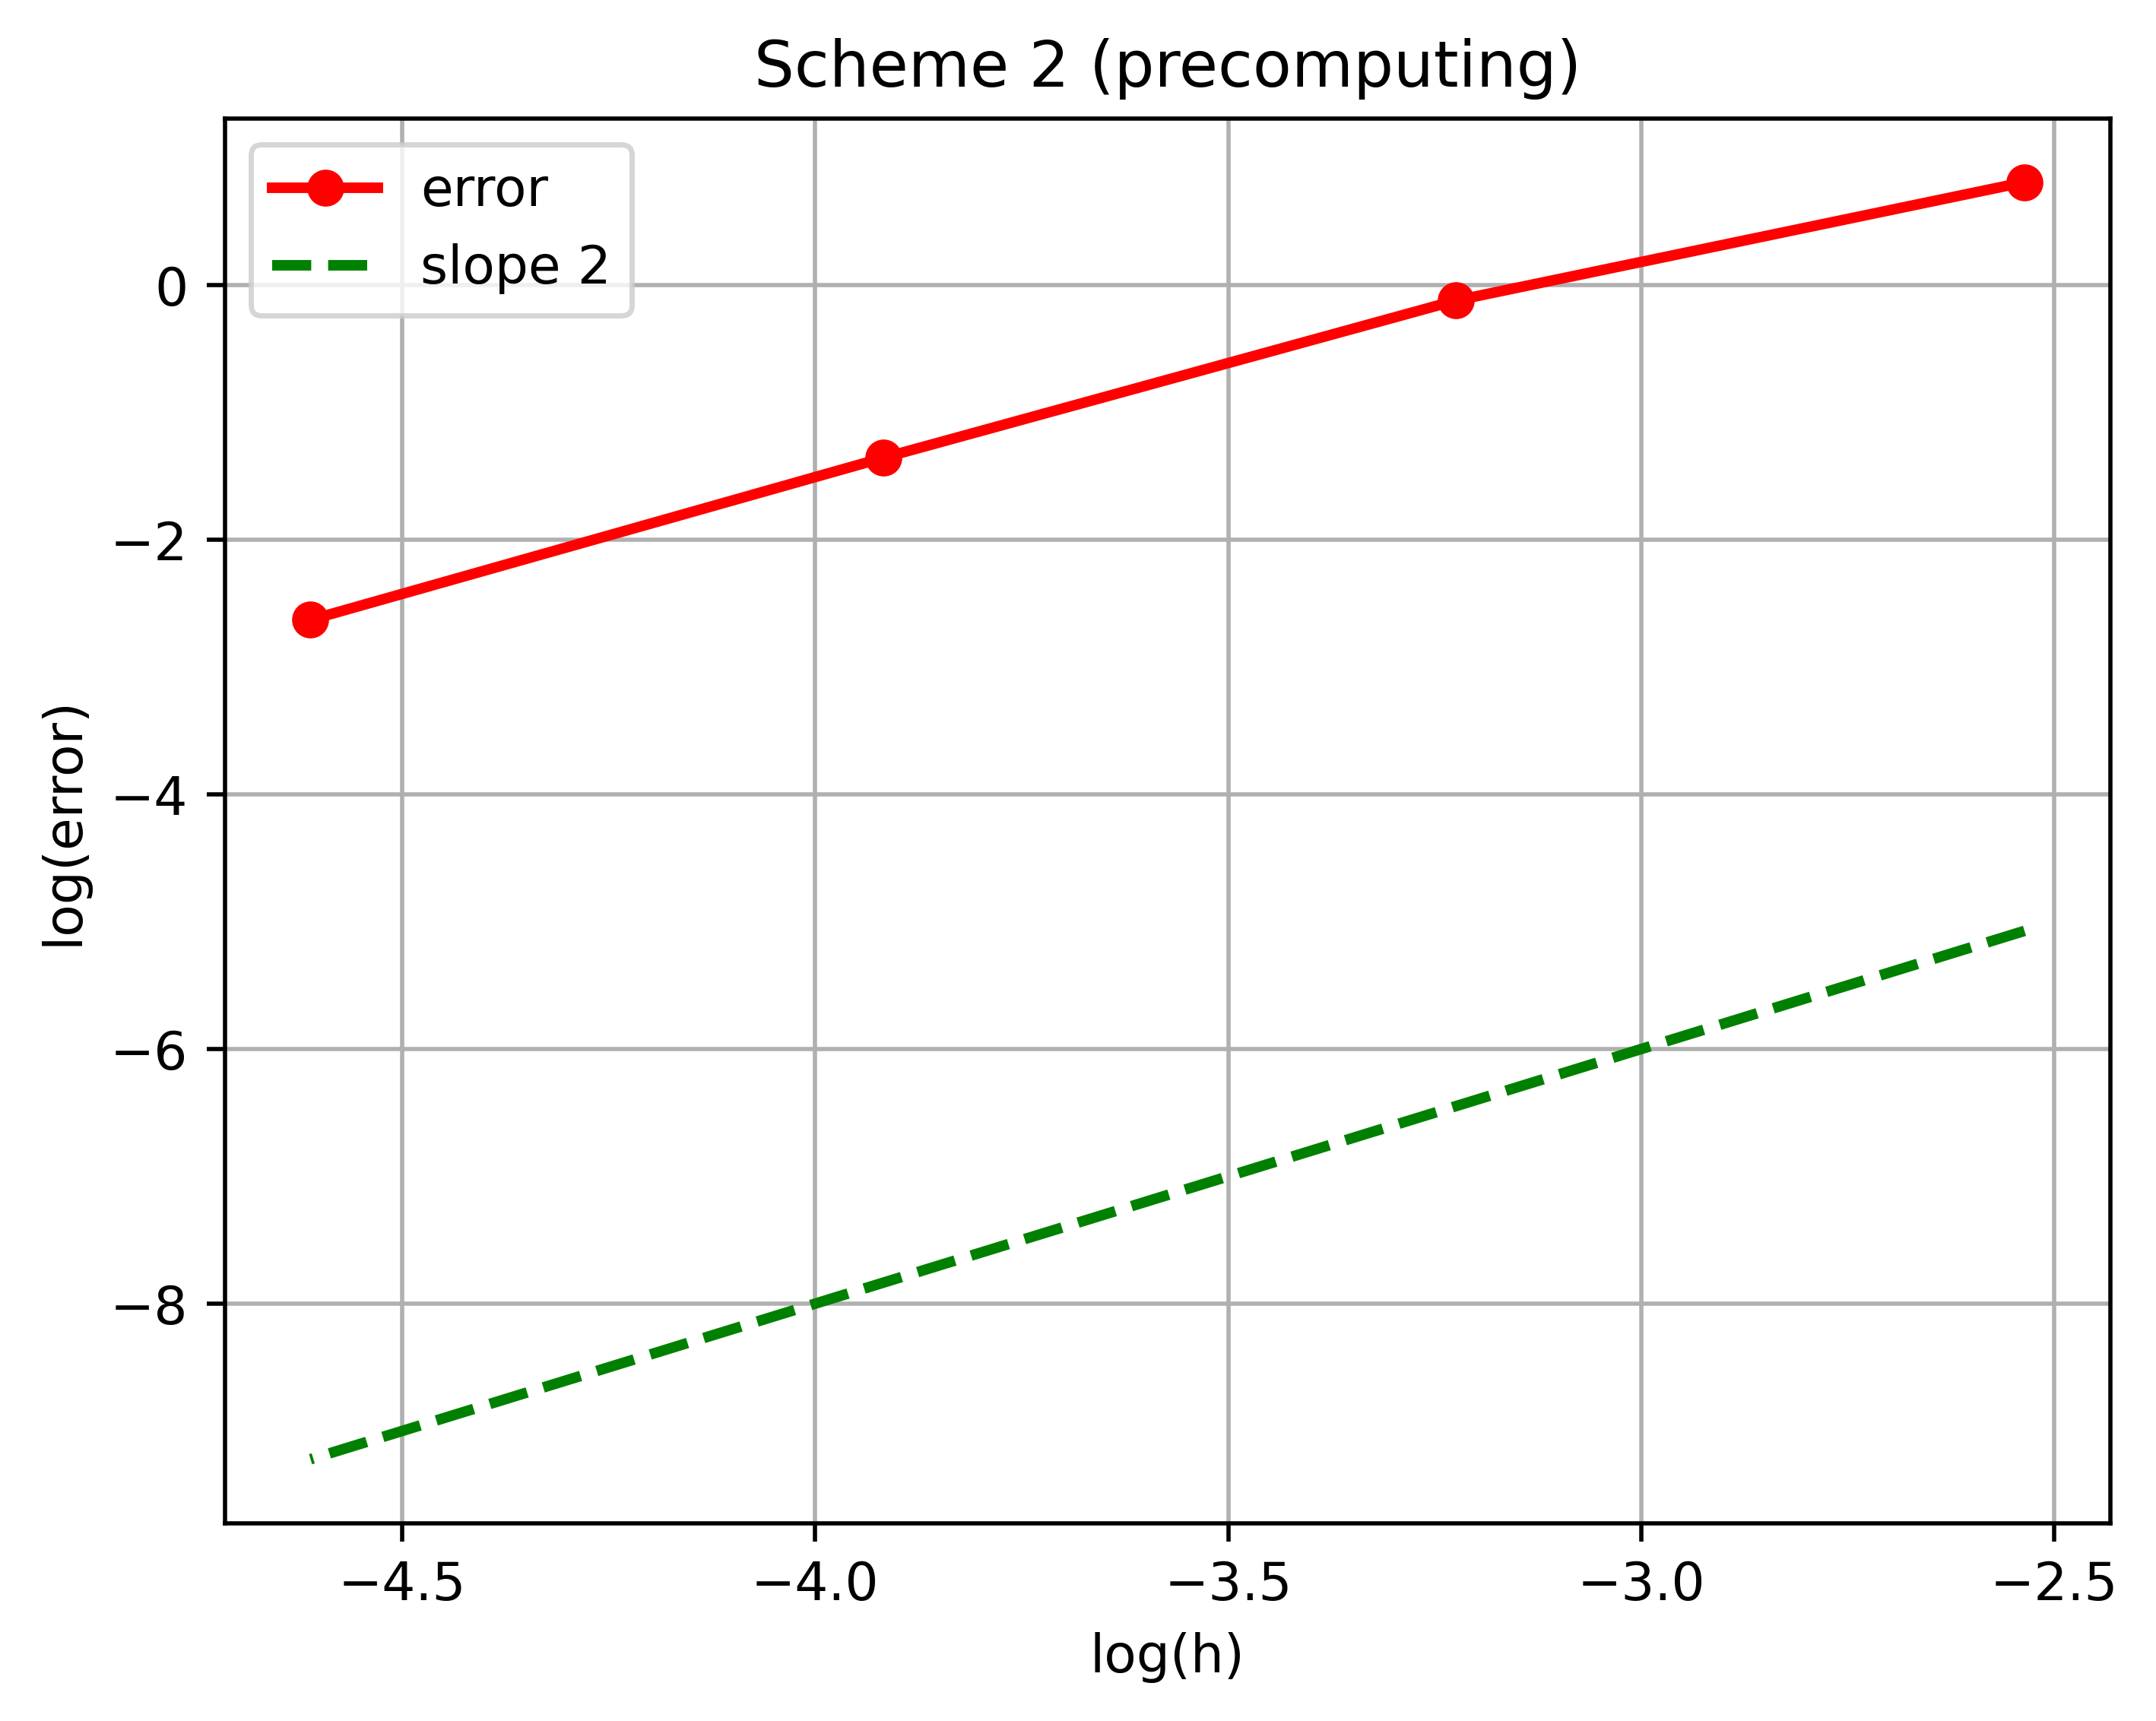

In [5]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(dpi=500)
#plt.plot(np.log(NX[:-1]), np.log(Error_scheme2), 'r-o', linewidth=2)
plt.plot(np.log(hs[1:]), np.log(Error_in_scheme), 'r-o', linewidth=2)
#plt.plot(np.log(NX[:-1]), np.log(Error_scheme1), 'r-o', linewidth=2)
#plt.plot(np.log(NX[:-1]), np.log(Error_scheme1_pre), 'r-o', linewidth=2)
#plt.plot(np.log(nxs[1:]), -2*np.log(nxs[1:]), 'g--', linewidth=2)
plt.plot(np.log(hs[1:]), 2*np.log(hs[1:]), 'g--', linewidth=2)

plt.legend([r'error', r'slope 2'])
plt.title('Scheme 2 (precomputing)')
plt.xlabel('log(h)')
plt.ylabel('log(error)')
plt.grid()
plt.show()